# Tutorial 9: DynaQ

### Tasks to be done:

1. Complete code for Planning step update. (search for "TODO" marker)
2. Compare the performance (train and test returns) for the following values of planning iterations = **[0, 1, 2, 5, 10]**
3. For each value of planning iteration, average the results on **100 runs** (due to the combined stochasticity in the env, epsilon-greedy and planning steps, we need you to average the results over a larger set of runs)

In [25]:
!pip install gymnasium

In [48]:
import tqdm
import random
import numpy as np
import gymnasium as gym
from matplotlib import pyplot as plt

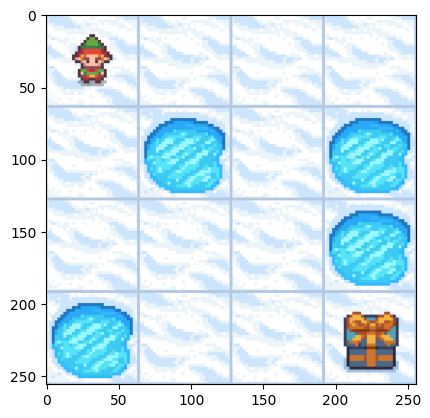

In [49]:
env = gym.make('FrozenLake-v1', is_slippery = True, render_mode = 'rgb_array')
env.reset()

# https://gymnasium.farama.org/environments/toy_text/frozen_lake

# if pygame is not installed run: "!pip install gymnasium[toy-text]"

plt.imshow(env.render())

In [63]:
class DynaQ:
    def __init__(self, num_states, num_actions, gamma=0.99, alpha=0.01, epsilon=0.25):
        self.num_states = num_states
        self.num_actions = num_actions
        self.gamma = gamma  # discount factor
        self.alpha = alpha  # learning rate
        self.epsilon = epsilon  # exploration rate
        self.q_values = np.zeros((num_states, num_actions))  # Q-values
        self.model = {}  # environment model, mapping state-action pairs to next state and reward
        self.visited_states = []  # dictionary to track visited state-action pairs

    def choose_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.num_actions)
        else:
            return np.argmax(self.q_values[state])

    def update_q_values(self, state, action, reward, next_state):
        # Update Q-value using Q-learning
        best_next_action = np.argmax(self.q_values[next_state])
        td_target = reward + self.gamma * self.q_values[next_state][best_next_action]
        td_error = td_target - self.q_values[state][action]
        self.q_values[state][action] += self.alpha * td_error

    def update_model(self, state, action, reward, next_state):
        # Update model with observed transition
        self.model[(state, action)] = (reward, next_state)

    def planning(self, plan_iters):
        # Perform planning using the learned model
        for _ in range(plan_iters):
            # TODO
            # WRITE CODE HERE FOR TASK 1
            # Update q-value by sampling state-action pairs
            if not self.visited_states:
                continue  # Skip planning if no experiences have been gathered
            state, action = self.sample_state_action()
            reward, next_state = self.model[(state, action)]
            self.update_q_values(state, action, reward, next_state)

    def sample_state_action(self):
        # Sample a state-action pair from the dictionary of visited state-action pairs
        state_action = random.sample(self.visited_states, 1)
        state, action = state_action[0]
        return state, action

    def learn(self, state, action, reward, next_state, plan_iters):
        # Update Q-values, model, and perform planning
        self.update_q_values(state, action, reward, next_state)
        self.update_model(state, action, reward, next_state)

        # Update the visited state-action value
        self.visited_states.append((state, action))
        self.planning(plan_iters)

In [64]:
class Trainer:
    def __init__(self, env, gamma = 0.99, alpha = 0.01, epsilon = 0.25):
        self.env = env
        self.agent = DynaQ(env.observation_space.n, env.action_space.n, gamma, alpha, epsilon)

    def train(self, num_episodes = 1000, plan_iters = 10):
        # training the agent
        all_returns = []
        for episode in range(num_episodes):
            state, _ = self.env.reset()
            done = False
            episodic_return = 0
            while not done:
                action = self.agent.choose_action(state)
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                episodic_return += reward
                self.agent.learn(state, action, reward, next_state, plan_iters)
                state = next_state
                done = terminated or truncated
            all_returns.append(episodic_return)

        return all_returns

    def test(self, num_episodes=500):
        # testing the agent
        all_returns = []
        for episode in range(num_episodes):
            episodic_return = 0
            state, _ = self.env.reset()
            done = False
            while not done:
                action = np.argmax(self.agent.q_values[state]) # Act greedy wrt the q-values
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                episodic_return += reward
                state = next_state
                done = terminated or truncated
            all_returns.append(episodic_return)
        return all_returns

In [65]:
# Example usage:
env = gym.make('FrozenLake-v1', is_slippery = True)
agent = Trainer(env, alpha=0.01, epsilon=0.25)
train_returns = agent.train(num_episodes = 1000, plan_iters = 10)
eval_returns = agent.test(num_episodes = 1000)
print(sum(eval_returns))

759.0


TODO:
- Compare the performance (train and test returns) for the following values of planning iterations = [0, 1, 2, 5, 10]
- For each value of planning iteration, average the results on 100 runs (due to the combined stochasticity in the env, epsilon-greedy and planning steps, we need you to average the results over a larger set of runs)

---

Sample Skeleton Code:

for pi in plan_iter:

&emsp; for 100 times:

&emsp;&emsp; train(pi)

&emsp;&emsp; test()

&emsp; print(avg_performance)

# **Task 2:  Comparing Performance for Different Planning Iterations**

In [79]:
plan_iters_list = [0, 1, 2, 5, 10]
performance_results = {}
env = gym.make('FrozenLake-v1', is_slippery=True)
for plan_iters in plan_iters_list:
    trainer = Trainer(env, alpha=0.01, epsilon=0.25)
    train_results = trainer.train(num_episodes=1000, plan_iters=plan_iters)
    test_results = trainer.test(num_episodes=1000)
    performance_results[plan_iters] = {
        'average_train_return': np.mean(train_results),
        'average_test_return': np.mean(test_results)
    }

print("Performance for different planning iterations:")
for pi, results in performance_results.items():
    print(f"Planning Iterations = {pi}: Train Avg = {results['average_train_return']}, Test Avg = {results['average_test_return']}")

Performance for different planning iterations:
Planning Iterations = 0: Train Avg = 0.048, Test Avg = 0.14
Planning Iterations = 1: Train Avg = 0.038, Test Avg = 0.142
Planning Iterations = 2: Train Avg = 0.042, Test Avg = 0.294
Planning Iterations = 5: Train Avg = 0.13, Test Avg = 0.653
Planning Iterations = 10: Train Avg = 0.0, Test Avg = 0.0


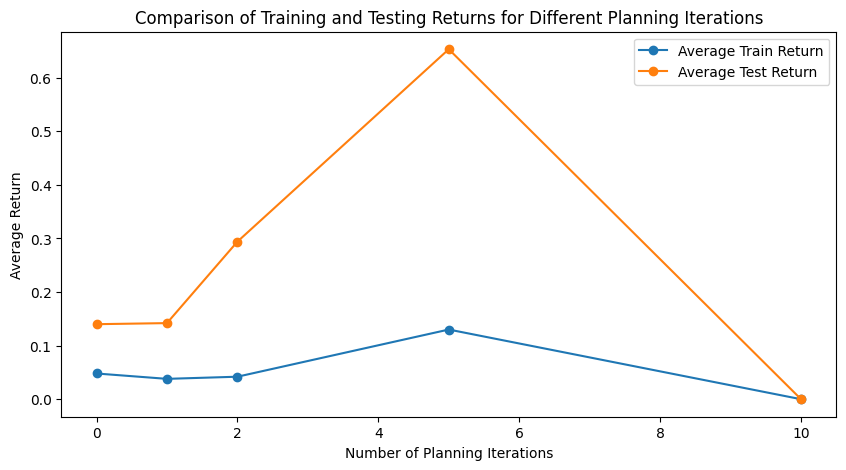

In [80]:
train_performances = [result['average_train_return'] for result in performance_results.values()]
test_performances = [result['average_test_return'] for result in performance_results.values()]
plt.figure(figsize=(10, 5))
plt.plot(plan_iters_list, train_performances, marker='o', label='Average Train Return')
plt.plot(plan_iters_list, test_performances, marker='o', label='Average Test Return')
plt.xlabel('Number of Planning Iterations')
plt.ylabel('Average Return')
plt.title('Comparison of Training and Testing Returns for Different Planning Iterations')
plt.legend()
plt.show()

# **Task 3: Averaging Results Over 100 Runs**

In [68]:
avg_train_results = {}
avg_test_results = {}
env = gym.make('FrozenLake-v1', is_slippery=True)

for plan_iters in plan_iters_list:
    train_returns = []
    test_returns = []

    for _ in tqdm.tqdm(range(100)):
        trainer = Trainer(env, alpha=0.01, epsilon=0.25)
        train_result = trainer.train(num_episodes=1000, plan_iters=plan_iters)
        train_returns.append(np.mean(train_result))
        test_result = trainer.test(num_episodes=1000)
        test_returns.append(np.mean(test_result))
    avg_train_results[plan_iters] = np.mean(train_returns)
    avg_test_results[plan_iters] = np.mean(test_returns)

print("Average Train Returns for different planning iterations:")
for pi, result in avg_train_results.items():
    print(f"Planning Iterations = {pi}: {result}")
print("\nAverage Test Returns for different planning iterations:")
for pi, result in avg_test_results.items():
    print(f"Planning Iterations = {pi}: {result}")

100%|██████████| 100/100 [03:24<00:00,  2.05s/it]

Average Train Returns for different planning iterations:
Planning Iterations = 0: 0.013809999999999998
Planning Iterations = 1: 0.02155
Planning Iterations = 2: 0.02297
Planning Iterations = 5: 0.02958
Planning Iterations = 10: 0.033530000000000004

Average Test Returns for different planning iterations:
Planning Iterations = 0: 0.049760000000000006
Planning Iterations = 1: 0.10068999999999999
Planning Iterations = 2: 0.10052000000000001
Planning Iterations = 5: 0.16008
Planning Iterations = 10: 0.22011000000000006


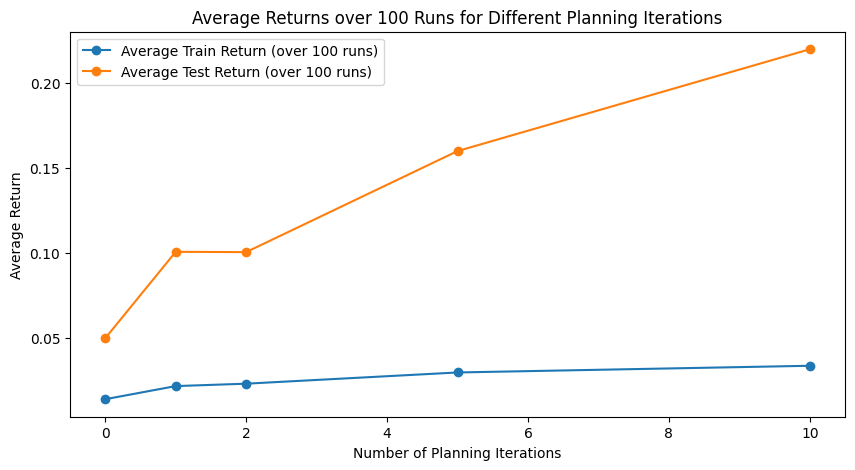

In [69]:
train_avgs = list(avg_train_results.values())
test_avgs = list(avg_test_results.values())
plt.figure(figsize=(10, 5))
plt.plot(plan_iters_list, train_avgs, marker='o', label='Average Train Return (over 100 runs)')
plt.plot(plan_iters_list, test_avgs, marker='o', label='Average Test Return (over 100 runs)')
plt.xlabel('Number of Planning Iterations')
plt.ylabel('Average Return')
plt.title('Average Returns over 100 Runs for Different Planning Iterations')
plt.legend()
plt.show()

# **Inference**
- **Task 2 Inferences**
  - The average training return appears to increase significantly as the number of planning iterations increases, indicating that additional planning steps help the agent to learn more effective policies during training.
  - The average test return also increases with the number of planning iterations, suggesting that the policies learned during training generalize well during the testing phase.

- **Task 3 Inferences**
  - Averaging over 100 runs shows a consistent increase in both training and test returns as the number of planning iterations increases, confirming that the benefit of planning steps is not due to random chance.
  - The performance during testing phases keeps improving with more planning iterations, which supports the hypothesis that more planning contributes to a more robust policy.
  - The rate of improvement in test returns seems to taper off slightly, suggesting diminishing returns as the number of planning iterations becomes very high.